# Modeling Whole Sequence

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time

mpl.rcParams['figure.dpi']= 100 
plt.rcParams["axes.grid"] = False
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [22]:
# Read the regions -----------

# CircadianRegions = '../output/CircadianRegions_2kb.csv'
Regions = '../output/circANDnoncirc_Regions_2kb.csv'
Regions = pd.read_csv(Regions)

#********************************************************
#           TESTING ONLY!!! (comment!)
# Regions = Regions.sample(frac=0.5, replace=False, random_state=5461) # Sample a fraction of the df
#********************************************************

# get colnames
# Regions.columns.tolist()

# Prepare data -----------
# data_df = Regions[['gene','JTK_adjphase','region2kb']] # keep relevant cols
data_df = Regions[['gene','Label','region2kb']] # keep relevant cols
data_df = data_df.sort_values('gene') # make sure df is sorted by gene
# CircadianRegions = None
data_df

,gene,Label,region2kb
0,BrA03.01G007200,NonCircadian,ATCGATTTGTGAATCCTAACTATGTATATATTGTGAATCTGGGTTT...
1,BrA03.01G008300,Circadian,GATGCTTGTCGCTCAAGGTAAAGCCTTCCACGGGTTTGTAATAAGG...
3,BrA03.01G012800,Circadian,TAAAACTGATTTCAGTAAGTGCAGCAACTTCTATTCTCTCTTTTCT...
2,BrA03.01G012900,Circadian,GTGAAGACTTTACTTTGAATCTAAAGAGGTGACACCTTTGTTTTTC...
4,BrA03.01G013500,NonCircadian,ACGTGTTGGGTGTTTGTCTTTGGCAGGTACAATTTTATGCCGTTAG...
...,...,...,...
2622,BraR500.10G282300,Circadian,ACGGTTCGCTTCGATTTTGAGGCCATCCATTTTTCTCCCTTTTTAA...
3065,BraR500.10G284500,NonCircadian,AAAAAGGGTTCGAGAATGTTCGATGGCTGTGAGGTTAAAACCCTAG...
2623,BraR500.10G286700,Circadian,TAGAGAGAGTCATAGAAGGAGTTTATATAGGGAACTCTCTCTGGCT...
3066,BraR500.10G289400,NonCircadian,CTCAAATACTTCGGCTATTGCTTCCCGACAAATATAATCATTTACG...


In [23]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert labels to numerical values
label_encoder = LabelEncoder()
data_df['Label'] = label_encoder.fit_transform(data_df['Label'])

# Tokenize and pad DNA sequences (T=1, A=2, C=3, G=4)
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(data_df['region2kb'])
sequences = tokenizer.texts_to_sequences(data_df['region2kb'])
X = pad_sequences(sequences)
y = data_df['Label']

In [12]:
%%time
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

CPU times: user 59.1 ms, sys: 19 ms, total: 78.2 ms
Wall time: 171 ms


In [17]:
%%time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=X.shape[1]))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


CPU times: user 89.2 ms, sys: 1.83 ms, total: 91 ms
Wall time: 38.1 ms


In [18]:
%%time

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
100/100 [==============================] - 3s 23ms/step - loss: 0.6891 - accuracy: 0.6004 - val_loss: 0.6608 - val_accuracy: 0.6220
Epoch 2/20
100/100 [==============================] - 2s 22ms/step - loss: 0.5897 - accuracy: 0.6508 - val_loss: 0.6819 - val_accuracy: 0.6120
Epoch 3/20
100/100 [==============================] - 2s 22ms/step - loss: 0.4012 - accuracy: 0.8398 - val_loss: 0.8274 - val_accuracy: 0.5770
Epoch 4/20
100/100 [==============================] - 2s 22ms/step - loss: 0.1317 - accuracy: 0.9715 - val_loss: 1.1413 - val_accuracy: 0.5507
Epoch 5/20
100/100 [==============================] - 2s 21ms/step - loss: 0.0379 - accuracy: 0.9962 - val_loss: 1.3696 - val_accuracy: 0.5532
Epoch 6/20
100/100 [==============================] - 2s 22ms/step - loss: 0.0115 - accuracy: 0.9978 - val_loss: 1.5477 - val_accuracy: 0.5645
Epoch 7/20
100/100 [==============================] - 2s 21ms/step - loss: 0.0063 - accuracy: 0.9981 - val_loss: 1.6869 - val_accuracy: 0.5682

In [19]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")


25/25 [==============================] - 0s 5ms/step - loss: 2.3597 - accuracy: 0.5695
Test Loss: 2.3597
Test Accuracy: 56.95%


## Predictions


In [20]:
# Extract sequences for the first 5 genes, for example
gene_sequences = data_df['region2kb'].iloc[:5]
sequences = tokenizer.texts_to_sequences(gene_sequences)
X_pred = pad_sequences(sequences, maxlen=X.shape[1])
X_pred

array([[2, 1, 3, ..., 3, 1, 1],
       [4, 2, 1, ..., 2, 2, 4],
       [1, 2, 2, ..., 1, 3, 2],
       [4, 1, 4, ..., 1, 1, 1],
       [2, 3, 4, ..., 2, 3, 3]], dtype=int32)

In [21]:
# Predicitons
predictions = model.predict(X_pred)

# Convert predictions to class labels (0 or 1)
predicted_labels = (predictions > 0.5).astype(int)

# Map numerical labels back to original labels
predicted_labels = label_encoder.inverse_transform(predicted_labels)

# Get the gene names for the first 5 genes
gene_names = data_df['gene'].iloc[:5]

# Create a DataFrame to display gene names and predicted labels
predictions_df = pd.DataFrame({'Gene': gene_names, 'Predicted Label': predicted_labels})
print(predictions_df)


1/1 [==============================] - 0s 65ms/step
              Gene Predicted Label
0  BrA03.01G007200    NonCircadian
1  BrA03.01G008300       Circadian
3  BrA03.01G012800       Circadian
2  BrA03.01G012900       Circadian
4  BrA03.01G013500    NonCircadian


/Users/joanbarreto/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Metrics

- **Precision:** Precision is the ratio of correctly predicted positive observations (True Positives) to the total predicted positive observations (True Positives + False Positives). It measures the accuracy of positive predictions.

- **Recall:** Recall is the ratio of correctly predicted positive observations (True Positives) to the total actual positive observations (True Positives + False Negatives). It measures the ability of the model to identify all relevant instances.

- **F1-Score:** The F1-score is the harmonic mean of precision and recall. It provides a balanced assessment of a binary classification model, where an F1 score above 0.9 indicates exceptional performance with both high precision and recall, while an F1 score below 0.3 suggests poor model performance with significant false positives and difficulty in correctly identifying positive instances.

- **ROC-AUC Score:** ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) measures the area under the ROC curve, which is a plot of the True Positive Rate (recall) against the False Positive Rate at various threshold settings. It indicates the model's ability to distinguish between classes.

In [24]:
from sklearn.metrics import classification_report, roc_auc_score

# Assuming you already have predictions for the test data
# For example:
predictions = model.predict(X_test)

# Convert predictions to binary labels (0 or 1) based on a threshold (e.g., 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate and print classification report
print(classification_report(y_test, predicted_labels))

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, predictions)
print(f"ROC-AUC Score: {roc_auc:.4f}")

25/25 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.42      0.34      0.38       302
           1       0.64      0.71      0.67       497

    accuracy                           0.57       799
   macro avg       0.53      0.53      0.52       799
weighted avg       0.55      0.57      0.56       799

ROC-AUC Score: 0.5424


# Sequences as images

array([[1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.]])

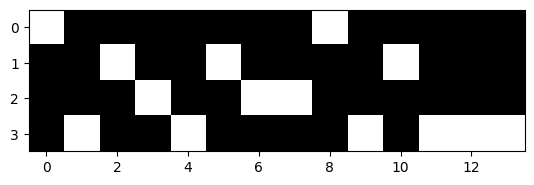

In [35]:
# Read the regions
Regions = '../output/circANDnoncirc_Regions_2kb.csv'
data_df = pd.read_csv(Regions)

# Sort the dataframe by gene for consistency
data_df = data_df.sort_values('gene')

# Define a function to one-hot encode a sequence
def one_hot_encode_sequence(sequence):
    bases = ['A', 'T', 'C', 'G']
    one_hot_encoded = np.zeros((len(bases), len(sequence)))
    for i, base in enumerate(sequence):
        if base in bases:
            one_hot_encoded[bases.index(base), i] = 1
    return one_hot_encoded

# Example
one_hot_encode_sequence('AGTCGTCCAGTGGG')
plt.imshow(one_hot_encode_sequence('AGTCGTCCAGTGGG'),cmap='gray')

In [39]:
# Apply one-hot encoding to the 'region2kb' column
data_df['one_hot_encoded'] = data_df['region2kb'].apply(one_hot_encode_sequence)

# Or convert them to a list of arrays
one_hot_encoded_sequences = data_df['one_hot_encoded'].tolist()

In [63]:
%%time

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Convert the list of one-hot encoded sequences to a 3D numpy array
# Each sequence is a 2D matrix (4, 2000), and you have a list of these matrices
X = np.array(one_hot_encoded_sequences)

# Convert labels to numerical values (if they are not already)
y = data_df['Label'].map({'Circadian': 1, 'NonCircadian': 0}).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Build the neural network model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(4, 2000, 1))) 
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))  # Added padding
model.add(MaxPooling2D(pool_size=(1, 2)))  

# Flatten the 2D feature maps to 1D
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification, so one output neuron with sigmoid activation

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Reshape input data to match the expected shape (add a channel dimension)
X_train = X_train.reshape(X_train.shape[0], 4, 2000, 1)
X_test = X_test.reshape(X_test.shape[0], 4, 2000, 1)

CPU times: user 154 ms, sys: 381 ms, total: 535 ms
Wall time: 263 ms


In [64]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Epoch 1/10
100/100 [==============================] - 8s 71ms/step - loss: 0.7789 - accuracy: 0.6014 - val_loss: 0.6630 - val_accuracy: 0.6220
Epoch 2/10
100/100 [==============================] - 7s 68ms/step - loss: 0.6635 - accuracy: 0.6058 - val_loss: 0.6677 - val_accuracy: 0.6220
Epoch 3/10
100/100 [==============================] - 7s 71ms/step - loss: 0.6156 - accuracy: 0.6477 - val_loss: 0.6777 - val_accuracy: 0.6220
Epoch 4/10
100/100 [==============================] - 7s 70ms/step - loss: 0.4159 - accuracy: 0.8404 - val_loss: 0.8032 - val_accuracy: 0.6258
Epoch 5/10
100/100 [==============================] - 7s 69ms/step - loss: 0.1500 - accuracy: 0.9675 - val_loss: 0.9550 - val_accuracy: 0.5857
Epoch 6/10
100/100 [==============================] - 7s 68ms/step - loss: 0.0308 - accuracy: 0.9987 - val_loss: 1.3074 - val_accuracy: 0.6033
Epoch 7/10
100/100 [==============================] - 7s 68ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 1.4428 - val_accuracy: 0.5745

25/25 [==============================] - 1s 21ms/step - loss: 1.7096 - accuracy: 0.5782
Test Loss: 1.709625482559204
Test Accuracy: 0.5782227516174316


In [66]:
predictions = model.predict(X_test)

# Convert predictions to binary labels (0 or 1) based on a threshold (e.g., 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate and print classification report
print(classification_report(y_test, predicted_labels))

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, predictions)
print(f"ROC-AUC Score: {roc_auc:.4f}")

25/25 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

           0       0.66      0.67      0.67       497
           1       0.44      0.42      0.43       302

    accuracy                           0.58       799
   macro avg       0.55      0.55      0.55       799
weighted avg       0.57      0.58      0.58       799

ROC-AUC Score: 0.5658


## Different parameters

In [68]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Convert the list of one-hot encoded sequences to a 3D numpy array
# Each sequence is a 2D matrix (4, 2000), and you have a list of these matrices
X = np.array(one_hot_encoded_sequences)

# Convert labels to numerical values (if they are not already)
y = data_df['Label'].map({'Circadian': 1, 'NonCircadian': 0}).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Build the neural network model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(4, 2000, 1)))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(1, 2)))

# Flatten the 2D feature maps to 1D
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))  # Adding dropout with a rate of 0.3 to prevent overfitting
model.add(Dense(1, activation='sigmoid'))

# Compile the model with a custom learning rate
custom_optimizer = Adam(learning_rate=0.0001)  # Adjust the learning rate here
model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])

# Reshape input data to match the expected shape (add a channel dimension)
X_train = X_train.reshape(X_train.shape[0], 4, 2000, 1)
X_test = X_test.reshape(X_test.shape[0], 4, 2000, 1)

In [69]:
%%time

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Epoch 1/10
100/100 [==============================] - 8s 72ms/step - loss: 0.6768 - accuracy: 0.5989 - val_loss: 0.6637 - val_accuracy: 0.6220
Epoch 2/10
100/100 [==============================] - 7s 71ms/step - loss: 0.6685 - accuracy: 0.6051 - val_loss: 0.6701 - val_accuracy: 0.6220
Epoch 3/10
100/100 [==============================] - 7s 71ms/step - loss: 0.6640 - accuracy: 0.6061 - val_loss: 0.6611 - val_accuracy: 0.6220
Epoch 4/10
100/100 [==============================] - 7s 70ms/step - loss: 0.6459 - accuracy: 0.6142 - val_loss: 0.6619 - val_accuracy: 0.6220
Epoch 5/10
100/100 [==============================] - 7s 70ms/step - loss: 0.6265 - accuracy: 0.6289 - val_loss: 0.6755 - val_accuracy: 0.6220
Epoch 6/10
100/100 [==============================] - 7s 68ms/step - loss: 0.5920 - accuracy: 0.6674 - val_loss: 0.6611 - val_accuracy: 0.6208
Epoch 7/10
100/100 [==============================] - 7s 68ms/step - loss: 0.5597 - accuracy: 0.7237 - val_loss: 0.6595 - val_accuracy: 0.6283

In [70]:
predictions = model.predict(X_test)

# Convert predictions to binary labels (0 or 1) based on a threshold (e.g., 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate and print classification report
print(classification_report(y_test, predicted_labels))

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, predictions)
print(f"ROC-AUC Score: {roc_auc:.4f}")

25/25 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       497
           1       0.46      0.30      0.36       302

    accuracy                           0.60       799
   macro avg       0.55      0.54      0.54       799
weighted avg       0.58      0.60      0.58       799

ROC-AUC Score: 0.5572


## Automating the search for hyperparameters
(Not working)

In [72]:
%%time

#GridSearchCV

from sklearn.model_selection import GridSearchCV

# Define hyperparameters and their possible values
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30],
    'dropout_rate': [0.2, 0.3, 0.4],
}

# Create the model (define the architecture)
model = Sequential()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


TypeError: Cannot clone object '<keras.engine.sequential.Sequential object at 0x7fb1e0197430>' (type <class 'keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [73]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define hyperparameters and their distributions
param_dist = {
    'learning_rate': uniform(0.001, 0.1),
    'batch_size': [32, 64, 128],
    'epochs': randint(10, 30),
    'dropout_rate': uniform(0.2, 0.4),
}

# Create the model (define the architecture)
model = Sequential()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, scoring='accuracy', cv=3)

# Fit the random search to your data
random_search.fit(X_train, y_train)

# Get the best hyperparameters and corresponding model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


TypeError: Cannot clone object '<keras.engine.sequential.Sequential object at 0x7fb274b2fe50>' (type <class 'keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [76]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Define the search space for hyperparameters
search_space = {
    'learning_rate': Real(0.001, 0.1, 'log-uniform'),
    'batch_size': Integer(32, 128),
    'epochs': Integer(10, 30),
    'dropout_rate': Real(0.2, 0.4),
}

# Create the model (define the architecture)
model = Sequential()

# Create a BayesSearchCV object
bayes_search = BayesSearchCV(estimator=model, search_spaces=search_space, scoring='accuracy', cv=3, n_iter=10)

# Fit the Bayesian search to your data
bayes_search.fit(X_train, y_train)

# Get the best hyperparameters and corresponding model
best_params = bayes_search.best_params_
best_model = bayes_search.best_estimator_

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


TypeError: Cannot clone object '<keras.engine.sequential.Sequential object at 0x7fb1e01cbb20>' (type <class 'keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.